In [ ]:
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd

gdf_casos_utm = pd.read_csv(r"outputs/casos_con_municerca.csv")


# 1) Parte de tu GeoDataFrame original
df = gdf_casos_utm.copy()

# 2) Creamos una columna ‘date’ apuntando al lunes ISO de cada year_week
df['date'] = pd.to_datetime(
    df['year_week'] + '-1',
    format='%G-W%V-%u',
    errors='coerce'
)

# 3) Ordenamos
df = df.sort_values(['municerca','date'])

# 4) Calculamos la suma acumulada de 4 semanas (excluyendo la actual)
#    Hacemos groupby por municerca, shift(1) para quitar la semana en curso,
#    y rolling sobre la serie de casos
df['casos_sum_4w'] = (
    df
      .groupby('municerca')['casos']
      .apply(lambda s: s.shift(1).rolling(window=4, min_periods=1).sum())
      .reset_index(level=0, drop=True)
)

# 5) Si necesitas también lags individuales, igual:
for lag in [1,2,3,4]:
    df[f'casos_lag_{lag}'] = (
        df
          .groupby('municerca')['casos']
          .shift(lag)
    )

# 6) (Opcional) Vuelves a “year_week” como índice, si lo quieres:
df = df.set_index('date')
df.index.name = None
gdf_casos_utm2=df.copy()


# Asegúrate de tener tu df ordenado
df_weekly = gdf_casos_utm.sort_values(['municerca','year_week'])

# Definimos las ventanas que queremos
ventanas = {
    2: 'casos_sum_2w',
    3: 'casos_sum_3w',
    4: 'casos_sum_4w'
}

for n, nombre in ventanas.items():
    # rolling window de tamaño n, sumamos y luego shift(1) para que no incluya la semana actual
    df_weekly[nombre] = (
        df_weekly
          .groupby('municerca')['casos']
          .rolling(window=n, min_periods=n)  # solo computa si hay n semanas completas
          .sum()
          .shift(1)                          # mueve la suma para que en t sea t−1...t−n
          .reset_index(level=0, drop=True)
    )

df_weekly=df_weekly.fillna(0)    
df_weekly.sort_values("year_week").head()
df_weekly['distancia_rio']=df_weekly['distancia_rio'].astype(float)
df_weekly['week_start'] = pd.to_datetime(
    df_weekly['year_week'] + '-1',
    format='%Y-W%W-%w'
)
df_weekly['Periodo'] = df_weekly['week_start'].dt.to_period('M').astype(str)
df_weekly.drop(["week_start"],axis=1,inplace=True)
df_weekly_1=df_weekly.copy()

df_weekly_1=df_weekly_1.sort_values(by=["municerca","year_week"])
df_weekly_1["NVDI"]=df_weekly_1["NVDI"].ffill()
df_weekly_1.head()

,municerca,year_week,distancia_grande_m,distancia_rio,distancia_verde_m,edad_diagnostico,sexo,casos,longitude,latitude,...,Mujeres de 25 a 59 años,Varones de 25 a 59 años,Personas de 25 a 59 años,Mujeres de 60 años o más,Varones de 60 años o más,Personas de 60 años o más,NVDI,casos_sum_2w,casos_sum_3w,casos_sum_4w
0,CGC 1,2023-W49,2443.666099,3092.285007,378.439032,29.379297,0.380315,0.0,-63.228004,-32.395903,...,18.52,22.23,40.75,16.05,14.81,30.86,0.415873,0.0,0.0,0.0
1,CGC 1,2023-W50,2443.666099,3092.285007,378.439032,29.379297,0.380315,0.0,-63.228004,-32.395903,...,18.52,22.23,40.75,16.05,14.81,30.86,0.415873,0.0,0.0,0.0
2,CGC 1,2023-W51,2443.666099,3092.285007,378.439032,29.379297,0.380315,0.0,-63.228004,-32.395903,...,18.52,22.23,40.75,16.05,14.81,30.86,0.415873,0.0,0.0,0.0
3,CGC 1,2023-W52,2443.666099,3092.285007,378.439032,29.379297,0.380315,0.0,-63.228004,-32.395903,...,18.52,22.23,40.75,16.05,14.81,30.86,0.415873,0.0,0.0,0.0
4,CGC 1,2024-W01,2443.666099,3092.285007,378.439032,29.379297,0.380315,0.0,-63.228004,-32.395903,...,18.52,22.23,40.75,16.05,14.81,30.86,0.415873,0.0,0.0,0.0


In [4]:

# asumiendo que gdf_zonas es tu GeoDataFrame de polígonos con columna 'municerca'
# por ejemplo:
# gdf_zonas = gpd.read_file("tus_polígonos.shp")[['municerca','geometry']]
gdf_municerca = gpd.read_file(r"Datos\infra y mov/Capa de Municercas/NuevaDistribucion2024.shp")
import geopandas as gpd
import pandas as pd

# 1) Asegura CRS idéntico y limpia geometrías
gdf = gdf_municerca.to_crs(epsg=4326)
gdf['geometry'] = gdf.geometry.buffer(0)

# 2) Spatial join consigo misma usando 'intersects'
nbrs = ( gpd
    .sjoin(gdf[['Nombre','geometry']],
           gdf[['Nombre','geometry']],
           how="inner",
           predicate="intersects")
    .query("Nombre_left != Nombre_right")
)

# 3) Genera la matriz (1 = vecinos, 0 = no vecinos)
adj = pd.crosstab(nbrs['Nombre_left'], nbrs['Nombre_right']).astype(int)

# 4) Asegura que todas las zonas aparezcan como índice y columna
zonas = gdf['Nombre'].tolist()
adj = adj.reindex(index=zonas, columns=zonas, fill_value=0)

adj2=pd.DataFrame(adj.to_records()).rename(columns={"Nombre_left":"municerca"})

adj2

,municerca,CGC 2,ZONA CENTRAL,MUNICERCA 4,MUNICERCA 5,MUNICERCA 2,CGC 1,MUNICERCA 3,MUNICERCA 1
0,CGC 2,0,1,0,1,0,0,0,0
1,ZONA CENTRAL,1,0,0,1,0,0,0,1
2,MUNICERCA 4,0,0,0,1,0,1,1,0
3,MUNICERCA 5,1,1,1,0,0,0,0,0
4,MUNICERCA 2,0,0,0,0,0,0,1,1
5,CGC 1,0,0,1,0,0,0,1,0
6,MUNICERCA 3,0,0,1,0,1,1,0,0
7,MUNICERCA 1,0,1,0,0,1,0,0,0


In [5]:
df_vecinos=pd.DataFrame(pd.pivot_table(df_weekly_1,index=['year_week'],columns="municerca",values="casos_sum_3w",aggfunc="mean").to_records())
df_vecinos['year_week'] = df_vecinos['year_week'].shift(-1)
df_vecinos=df_vecinos[:-1].fillna(0)

df_weekly2=pd.merge(df_weekly_1,df_vecinos,on=["year_week"],how="left").fillna(0)
df_weekly3=pd.merge(df_weekly2,adj2,on=["municerca"],how="left")
df_weekly3["Vecinos_total_x"],df_weekly3["Vecinos_total_y"]=0,0
for c in df_vecinos.columns[1:]:

    df_weekly3[c+"_x"]=df_weekly3[c+"_x"]*df_weekly3[c+"_y"]
    df_weekly3[c+"_y"]=1000*df_weekly3[c+"_x"]/df_weekly3["Estimación poblacional"]
    for hh in ["x","y"]:
        df_weekly3["Vecinos_total_"+hh]=df_weekly3["Vecinos_total_"+hh]+df_weekly3[c+"_"+hh]
        df_weekly3.drop([c+"_"+hh],axis=1,inplace=True)

df_weekly=df_weekly3.copy()

In [ ]:


# --- 4) Ordena y crea lags de casos
df_weekly3 = df_weekly3.sort_values(['municerca','year_week'])
for lag in [1,2,3,4]:
    df_weekly[f'casos_lag_{lag}'] = (
        df_weekly
        .groupby('municerca')['casos']
        .shift(lag)
    )
# media móvil
df_weekly['casos_ma_4'] = (
    df_weekly
    .groupby('municerca')['casos']
    .transform(lambda x: x.shift(1).rolling(4).mean())
)



# --- 5) Variables de calendario
df_weekly['mes'] = pd.to_datetime(df_weekly["year_week"].str[:4].astype(str) + '-' + df_weekly["year_week"].str[6:8].astype(str) + '-1', format='%G-%V-%u').dt.month

# --- 6) Prepara X, y
# Lista de features: lags, clima, densidad, acccesos, CALMAT, educación, demografía, población, superficie, proximidades…

encuesta = [

    'CALMAT I','CALMAT II','CALMAT III','CALMAT IV','CALMAT V',
    'Acceso a Cloacas','Acceso a Gas de Red','Acceso a Agua de Red','Acceso a Electricidad',
      # y/o otras
    
]

geografia=[    'Superficie (Km cuadrados)',
    'Proximidad al río (m) (distancia mínima)', 'Proximidad al río (m) (distancia al centroide)',
    'Proximidad al río (m) (distancia máxima)',"NVDI"]

poblacion=['Estimación poblacional','Densidad poblacional']
demo = [  'Personas de 0 a 6 años',  'Mujeres de 0 a 6 años','Personas de 7 a 14 años','Personas de 15 a 24 años',
    'Personas de 25 a 59 años','Personas de 60 años o más' ,'Mujeres de 15 a 24 años', 
'Mujeres de 25 a 59 años', 'Mujeres de 60 años o más', 'Mujeres de 7 a 14 años','Varones de 0 a 6 años', 'Varones de 15 a 24 años', 'Varones de 25 a 59 años', 'Varones de 60 años o más', 
'Varones de 7 a 14 años','Mujeres (%)','Varones (%)',]
pobreza=['Hogares Indigentes', 'Hogares Pobres', 'Hogares Pobres No Indigentes','Personas Indigentes', 'Personas Pobres', 'Personas Pobres No Indigentes', 
]

educacion=[ 'UNEA: Primario Completo', 
'UNEA: Primario Incompleto', 'UNEA: Secundario Incompleto', 'UNEA: Sin Instrucción', 'UNEA: Superior y/o Universitario Incompleto',
'UNEA: Secundario Completo','UNEA: Superior y/o Universitario Completo',]

clima = ['t2m','d2m','tp']
acum=["casos_sum_2w","casos_sum_3w","casos_sum_4w"]
lags = [f'casos_lag_{l}' for l in [1,2,3,4]]
por_caso=['sexo','edad_diagnostico','distancia_grande_m', 'distancia_rio', 'distancia_verde_m', ]


#, 'latitude', 'longitude',

vecinos = [
    'Vecinos_total_x','Vecinos_total_y'
]

static=encuesta+demo+pobreza+educacion+poblacion

estaticas=encuesta+demo+pobreza+educacion
features =['casos_ma_4','mes'] + clima +acum+lags + vecinos+poblacion+geografia#+por_caso#+educacion#+estaticas

# # eliminamos filas con NaN en lags


## RandomForest

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Prepara X, y (ahora y = número de casos continuo)
df_model = df_weekly.dropna(subset=lags + ['casos_ma_4'])
X = df_model[features]
y = df_model['casos']

# --- 7) Validación con RandomForestRegressor
tscv = TimeSeriesSplit(n_splits=5)
model_r = RandomForestRegressor(n_estimators=100, random_state=42)

# Evaluamos MSE en CV (devuelve valores negativos)
neg_mse_scores = cross_val_score(
    model_r, X, y,
    cv=tscv,
    scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-neg_mse_scores)
print("RMSE CV:", np.round(rmse_scores, 2), "→ media:", np.round(rmse_scores.mean(), 2))

# --- Entrenamiento final sobre el último split
train_idx, test_idx = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model_r.fit(X_train, y_train)
y_pred = model_r.predict(X_test)

# --- Métricas de regresión
mse_rf = mean_squared_error(y_test, y_pred)
rmse_rf = np.sqrt(mse_rf)
mae_rf = mean_absolute_error(y_test, y_pred)
r2_rf = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse_rf:.2f}")
print(f"Test MAE : {mae_rf:.2f}")
print(f"Test R²  : {r2_rf:.3f}")


RMSE CV: [ 9.1   5.83 11.9   7.22  6.43] → media: 8.1
Test RMSE: 6.43
Test MAE : 2.09
Test R²  : 0.867


## XGB Regressor

In [8]:
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor

# --- 1) Prepara tus datos ---
# df_weekly: DataFrame con tus datos semanales ya cargado
# 'lags' es la lista de nombres de columnas de rezagos de dengue
# 'features' es la lista de variables predictoras que uses
df_model = df_weekly.dropna(subset=lags + ['casos_ma_4'])
X = df_model[features]
y = df_model['casos']

# Asegúrate de usar solo datos numéricos
X_numeric = X.select_dtypes(include=[np.number])
y_numeric = y.values

# --- 2) Configura validación temporal ---
tscv = TimeSeriesSplit(n_splits=5)

# --- 3) XGBoost Regressor ---
model_xgb = XGBRegressor(
    n_estimators=300,
    learning_rate=0.05,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

# CV para RMSE
neg_mse_xgb = cross_val_score(
    model_xgb,
    X_numeric.values,
    y_numeric,
    cv=tscv,
    scoring='neg_mean_squared_error',
    error_score='raise'
)
rmse_xgb = np.sqrt(-neg_mse_xgb)
print("XGB RMSE CV:", np.round(rmse_xgb, 2), "→ media:", np.round(rmse_xgb.mean(), 2))

# Entrenamiento final & evaluación
train_idx, test_idx = list(tscv.split(X_numeric))[ -1 ]
X_train, X_test = X_numeric.iloc[train_idx], X_numeric.iloc[test_idx]
y_train, y_test = y_numeric[train_idx], y_numeric[test_idx]

model_xgb.fit(X_train.values, y_train)
y_pred_xgb = model_xgb.predict(X_test.values)

mse_xgb  = mean_squared_error(y_test, y_pred_xgb)
rmse_xgb = np.sqrt(mse_xgb)
mae_xgb  = mean_absolute_error(y_test, y_pred_xgb)
r2_xgb   = r2_score(y_test, y_pred_xgb)

print(f"XGB Test RMSE: {rmse_xgb:.2f}")
print(f"XGB Test MAE : {mae_xgb:.2f}")
print(f"XGB Test R²  : {r2_xgb:.3f}")


XGB RMSE CV: [9.56 7.2  8.77 8.23 6.78] → media: 8.11
XGB Test RMSE: 6.78
XGB Test MAE : 2.06
XGB Test R²  : 0.852


## Gradient Boosting


In [9]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

# --- Prepara X, y (igual que antes) ---
df_model = df_weekly.dropna(subset=lags + ['casos_ma_4'])
X = df_model[features]
y = df_model['casos']

# --- Validación temporal ---
tscv = TimeSeriesSplit(n_splits=5)

# --- Definir el modelo ---
model_gb = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)

# --- CV para RMSE ---
neg_mse_scores = cross_val_score(
    model_gb, X, y,
    cv=tscv,
    scoring='neg_mean_squared_error'
)
rmse_scores = np.sqrt(-neg_mse_scores)
print("GB RMSE CV:", np.round(rmse_scores, 2),
      "→ media:", np.round(rmse_scores.mean(), 2))

# --- Entrena y test final ---
train_idx, test_idx = list(tscv.split(X))[-1]
X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

model_gb.fit(X_train, y_train)
y_pred = model_gb.predict(X_test)

# --- Métricas en test set ---
mse_gb  = mean_squared_error(y_test, y_pred)
rmse_gb  = np.sqrt(mse_gb)
mae_gb  = mean_absolute_error(y_test, y_pred)
r2_gb   = r2_score(y_test, y_pred)

print(f"Test GB RMSE: {rmse_gb:.2f}")
print(f"Test GB MAE : {mae_gb:.2f}")
print(f"Test GB R²  : {r2_gb:.3f}")


GB RMSE CV: [ 7.93  5.9  10.88  6.05  4.59] → media: 7.07
Test GB RMSE: 4.59
Test GB MAE : 1.91
Test GB R²  : 0.932


In [10]:
valores=(("RandomForest",rmse_rf,mae_rf,r2_rf),("XGBoosting",rmse_xgb,mae_xgb,r2_xgb),("GradientBoosting",rmse_gb,mae_gb,r2_gb))

df_results=pd.DataFrame(valores,columns=["Modelo","RMSE","MAE","R2"]).round(2)
display(df_results)

,Modelo,RMSE,MAE,R2
0,RandomForest,6.43,2.09,0.87
1,XGBoosting,6.78,2.06,0.85
2,GradientBoosting,4.59,1.91,0.93


In [11]:
df_results.round(2)

,Modelo,RMSE,MAE,R2
0,RandomForest,6.43,2.09,0.87
1,XGBoosting,6.78,2.06,0.85
2,GradientBoosting,4.59,1.91,0.93


In [12]:



# from sklearn.model_selection import RandomizedSearchCV

# param_dist = {
#   'n_estimators': [100, 200, 300, 500,800],
#   'max_depth': [3,4,5,6],
#   'learning_rate': [0.01,0.05,0.1],
#   'subsample': [0.6,0.8,1.0],
#   'colsample_bytree': [0.6,0.8,1.0]
# }

# search = RandomizedSearchCV(
#     XGBRegressor(random_state=42, verbosity=0),
#     param_distributions=param_dist,
#     n_iter=100,
#     scoring='neg_mean_squared_error',
#     cv=tscv,
#     verbose=1,
#     n_jobs=-1,
#     random_state=42
# )

# search.fit(X_numeric.values, y_numeric)
# print("Mejores parámetros:", search.best_params_)
# print("Mejor RMSE CV:", np.sqrt(-search.best_score_))

Top 10 features por importancia:
casos_lag_1        0.206480
casos_sum_2w       0.197994
casos_sum_3w       0.162264
Vecinos_total_x    0.097209
d2m                0.081526
Vecinos_total_y    0.066891
casos_lag_2        0.037402
casos_sum_4w       0.026747
t2m                0.026512
casos_ma_4         0.019610
dtype: float32


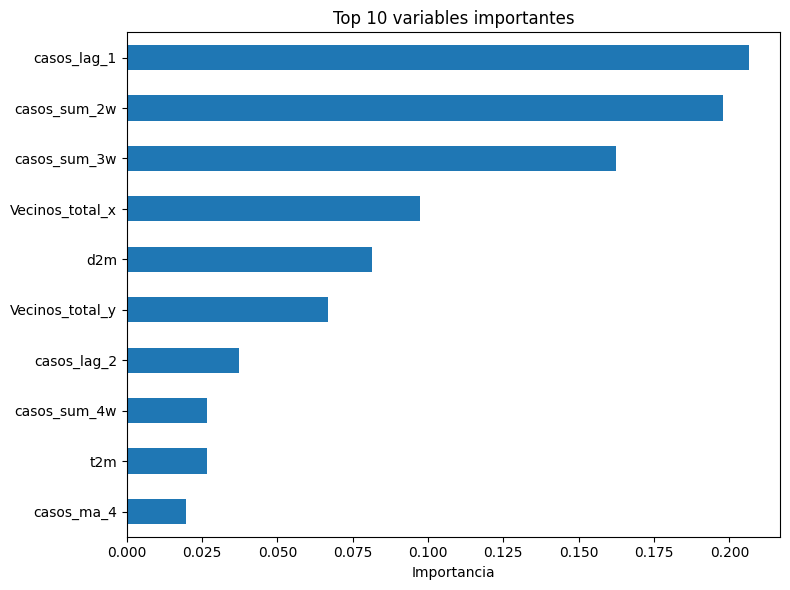

In [13]:


# 1) Extrae un Series con importancias y ordena de mayor a menor
feat_imp = pd.Series(
    model_xgb.feature_importances_,
    index=features
).sort_values(ascending=False)

# 2) Muestra las top 10
print("Top 10 features por importancia:")
print(feat_imp.head(10))

# # 3) Gráfico de barras horizontales de las 10 más importantes
# plt.figure(figsize=(8,6))
# feat_imp.head(10).plot.barh()
# plt.gca().invert_yaxis()
# plt.title("Top 10 variables importantes")
# plt.xlabel("Importancia")
# plt.show()


plt.figure(figsize=(8,6))
feat_imp.head(10).plot.barh()
plt.gca().invert_yaxis()
plt.title("Top 10 variables importantes")
plt.xlabel("Importancia")
plt.tight_layout()
plt.savefig(r"outputs\importancia_variables.png")  # <- guardás la imagen

# Predicciones futuras

### Predicción de variables climatologicas

In [14]:
import requests
import pandas as pd
from datetime import datetime, timedelta

import pandas as pd
from datetime import timedelta

# 1) Toma la última etiqueta “YYYY-Www”
max_yrwk = df_weekly["year_week"].max()   # ej. "2025-W22"

# 2) Crea un datetime apuntando al lunes de esa ISO‐week
monday = pd.to_datetime(
    max_yrwk + '-1',           # el “-1” indica lunes en %u
    format='%G-W%V-%u',
    errors='raise'
)

# 3) Convierte ese datetime a PeriodIndex semanal ISO (lunes inicio)
current_period = monday.to_period('W-MON')

# 4) Define la ventana de 4 semanas: desde la actual hasta +3 semanas
start_period = current_period
end_period   = current_period + 3

# Si lo que quieres es el rango de fechas:
start_date = start_period.to_timestamp()               # lunes de la primera semana
end_date   = end_period.to_timestamp() + timedelta(days=6)  # domingo de la cuarta

print("Semanas:", start_period, "→", end_period)
print("Fechas :", start_date.date(), "→", end_date.date())

# 5) (Opcional) si necesitas todas las etiquetas intermedias:
weeks_range = pd.period_range(start=start_period,
                             end=end_period,
                             freq='W-MON').strftime('%G-W%V')
print("Rango de etiquetas:", weeks_range.tolist())



print("Ventana de semanas:", start_period, "→", end_period)

f_ini  =start_date
f_fin  = end_date

# 2) Open-Meteo sólo ofrece hasta 16 días de forecast gratis
#    Así que limitamos forecast_days a 16 para no romper la llamada
hoy = pd.Timestamp.today().normalize()
dias_neces = (f_fin - hoy).days + 1
forecast_days = min(dias_neces, 16)

# 3) Preparar parámetros de la petición
params = {
    "latitude":      -32.407,
    "longitude":     -63.233,
    "hourly":        "temperature_2m,precipitation,relativehumidity_2m",
    "forecast_days": forecast_days,
    "timezone":      "auto"
}
url = "https://api.open-meteo.com/v1/forecast"

# 4) Llamada al API
r = requests.get(url, params=params)
r.raise_for_status()
data = r.json()["hourly"]

# 5) Montar DataFrame horario
df_h = pd.DataFrame(data)
df_h["time"] = pd.to_datetime(df_h["time"])
df_h = df_h.set_index("time")

# 6) Filtrar sólo la ventana de 4 semanas
mask = (df_h.index >= f_ini) & (df_h.index <= f_fin)
df_window = df_h.loc[mask]

# 7) Agregar a diario
daily = (
    df_window
    .resample("D")
    .agg({
        "temperature_2m":      "mean",   # °C
        "precipitation":       "sum",    # mm
        "relativehumidity_2m": "mean"    # %
    })
    .rename(columns={
        "temperature_2m":      "temp",
        "precipitation":       "prcp",
        "relativehumidity_2m": "rhum"
    })
)

# 8) (Opcional) Agregar por semana ISO
iso = daily.index.to_series().dt.isocalendar()
daily["year_week"] = (
    iso["year"].astype(str) + 
    "-W" + 
    iso["week"].astype(str).str.zfill(2)
)
weekly = (
    daily
    .groupby("year_week")
    .agg({
        "temp": "mean",    # temp media semanal
        "prcp": "sum",     # precip total semanal
        "rhum": "mean"     # humedad media semanal
    })
    .reset_index()
)

print(f"Ventana de {f_ini} a {f_fin} (máx. forecast_days={forecast_days})")
weekly=weekly.rename(columns={'temp':'t2m','prcp':'tp','rhum':'d2m'})
weekly

Semanas: 2025-08-26/2025-09-01 → 2025-09-16/2025-09-22
Fechas : 2025-08-26 → 2025-09-22
Rango de etiquetas: ['2025-W36', '2025-W37', '2025-W38', '2025-W39']
Ventana de semanas: 2025-08-26/2025-09-01 → 2025-09-16/2025-09-22
Ventana de 2025-08-26 00:00:00 a 2025-09-22 00:00:00 (máx. forecast_days=16)


,year_week,t2m,tp,d2m
0,2025-W35,14.202083,72.6,84.604167
1,2025-W36,9.837500,0.0,62.113095
2,2025-W37,16.548106,0.0,71.712121


In [15]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# --- 1) Función para pasar "YYYY-Www" → siguiente semana ISO "YYYY-Www"
def shift_year_week(yrwk: str) -> str:
    year, week = map(int, yrwk.split('-W'))
    # lunes de esa semana
    fecha = datetime.fromisocalendar(year, week, 1)
    # +1 semana
    nxt = fecha + timedelta(weeks=1)
    y, w, _ = nxt.isocalendar()
    return f"{y}-W{w:02d}"

# --- 2) Determinar la próxima semana
last_yrwk    = df_weekly['year_week'].iloc[-1]           # e.g. "2025-W28"
future_week  = shift_year_week(last_yrwk)               # → "2025-W29"

# future_week = "2025-W29"

## Proyección de casos 

In [16]:
static_df=df_weekly[static+['municerca']].drop_duplicates(static+['municerca'])

# --- 3) DataFrame base con todas las municercas
munis = df_weekly['municerca'].unique()
future_df = pd.DataFrame({
    'municerca': munis,
    'year_week': future_week
})

# --- 4) Añadir clima pronosticado
# Asumimos que tienes un DataFrame `weekly_fc` con columnas
# ['year_week','t2m','d2m','tp'] resultante de tu forecast.
future_df = future_df.merge(
    weekly[['year_week','t2m','d2m','tp']],
    on='year_week',
    how='left'
)

# --- 5) Calcular los últimos 4 lags y la media móvil de casos
# Pivotamos casos por municerca x week
cases_piv = df_weekly.pivot(
    index='municerca',
    columns='year_week',
    values='casos'
)

# Ordenamos las semanas y tomamos las 4 últimas
weeks_sorted = sorted(cases_piv.columns)
last4_weeks  = weeks_sorted[-4:]


# Para cada ventana N = 2,3,4, sumamos las N semanas previas
for n in [2, 3, 4]:
    cols_n = weeks_sorted[-n:]       # p.e. para n=3 toma las últimas 3
    # sumamos esas columnas; esto es la suma de casos de t-1...t-n
    future_df[f'casos_sum_{n}w'] = cases_piv[cols_n].sum(axis=1).values



# Para cada lag i, asignamos la semana correspondiente
# lag_1 → casos en W28, lag_2 → W27, etc.
for i, wk in enumerate(reversed(last4_weeks), start=1):
    future_df[f'casos_lag_{i}'] = cases_piv[wk].values

# Media móvil de las 4 últimas
future_df['casos_ma_4'] = cases_piv[last4_weeks].mean(axis=1).values

# --- 6) Mes de la semana futura (si lo necesitas)
year, week = map(int, future_week.split('-W'))
monday = datetime.fromisocalendar(year, week, 1)
future_df['mes'] = monday.month

# Y ya tienes:
# future_df: municerca | year_week("2025-W29") | t2m,d2m,tp | casos_lag_1…4 | casos_ma_4 | mes

vecinos_ultimo=pd.DataFrame(pd.pivot_table(future_df,index=["year_week"],columns='municerca',values="mes",aggfunc='count').to_records())
future_df2=pd.merge(future_df,static_df,on=["municerca"],how="left").fillna(0)

future_df3=pd.merge(future_df2,vecinos_ultimo,on=["year_week"],how="left").fillna(0)
future_df4=pd.merge(future_df3,adj2,on=["municerca"],how="left").fillna(0)
future_df4["Vecinos_total_x"],future_df4["Vecinos_total_y"]=0,0

for c in adj2["municerca"].unique():
    print(c)
    future_df4[c+"_x"]=future_df4[c+"_x"]*future_df4[c+"_y"]
    future_df4[c+"_y"]=1000*future_df4[c+"_x"]/future_df4["Estimación poblacional"]
    for hh in ["x","y"]:
        future_df4["Vecinos_total_"+hh]=future_df4["Vecinos_total_"+hh]+future_df4[c+"_"+hh]
        future_df4.drop(c+"_"+hh,axis=1,inplace=True)
        # future_df4["Vecinos_y"]=future_df4["Vecinos_y"]+future_df4[c+"_y"]
future_df4.head()

df_weekly_reset = df_weekly.reset_index(drop=True)
future_df4_reset = future_df4.reset_index(drop=True)

# Ahora concat
df_weekly_reset = pd.concat([df_weekly_reset, future_df4_reset], ignore_index=True)

CGC 2
ZONA CENTRAL
MUNICERCA 4
MUNICERCA 5
MUNICERCA 2
CGC 1
MUNICERCA 3
MUNICERCA 1


In [17]:
df_weekly_reset

# Obtener la última fila
last_row = df_weekly_reset.iloc[-1]

# Filtrar columnas con NaN en esa fila
cols_with_nan = last_row[last_row.isnull()].index.tolist()

print("Columnas con NaN en la última fila:", cols_with_nan)


Columnas con NaN en la última fila: ['distancia_grande_m', 'distancia_rio', 'distancia_verde_m', 'edad_diagnostico', 'sexo', 'casos', 'longitude', 'latitude', 'Superficie (Km cuadrados)', 'Proximidad al río (m) (distancia mínima)', 'Proximidad al río (m) (distancia al centroide)', 'Proximidad al río (m) (distancia máxima)', 'NVDI', 'Periodo']


### Predicción de casos en 'x' semanas

In [18]:
import numpy as np
from sklearn.ensemble          import RandomForestRegressor
from sklearn.model_selection   import TimeSeriesSplit, cross_val_score
from sklearn.metrics           import mean_squared_error, mean_absolute_error, r2_score

# --- 1) Prepara X,y continuos (mismas features que en clasificación)
# features = lags + ['casos_ma_4','mes'] + static + clima + demo + vecinos + acum

df_model = df_weekly_reset.dropna(subset=features)
X        = df_model[features]
y_cases  = df_model['casos']

# --- 2) Validación cruzada (opcional)
tscv = TimeSeriesSplit(n_splits=5)
reg   = RandomForestRegressor(n_estimators=100, random_state=42)

scores_rmse = np.sqrt(
    -cross_val_score(
        reg, X, y_cases, cv=tscv,
        scoring='neg_mean_squared_error'
    )
)
print("CV RMSE:", np.round(scores_rmse,1), "→ mean:", scores_rmse.mean().round(1))

# --- 3) Entrena en el último fold
train_idx, test_idx = list(tscv.split(X))[-1]
X_train, X_test   = X.iloc[train_idx], X.iloc[test_idx]
y_train, y_test   = y_cases.iloc[train_idx], y_cases.iloc[test_idx]

reg.fit(X_train, y_train)

# --- 4) Evalúa en test
y_pred_test = reg.predict(X_test)
mse  = mean_squared_error(y_test, y_pred_test)
rmse = np.sqrt(mse)
mae  = mean_absolute_error(y_test, y_pred_test)
r2   = r2_score(y_test, y_pred_test)

print(f"Test RMSE: {rmse:.1f} casos")
print(f"Test MAE : {mae:.1f} casos")
print(f"Test R²  : {r2:.2f}")

# --- 5) Predice cantidad de casos en future_df4
df_pred = future_df4.copy()
# Asegura que future_df4 tiene todas las features
for c in set(features) - set(df_pred.columns):
    df_pred[c] = 0
X_future = df_pred[features]

df_pred['casos_pred'] = reg.predict(X_future)

df_pred[['municerca','year_week','casos_pred']]


CV RMSE: [ 9.1  5.8 11.9  7.2  6.4] → mean: 8.1
Test RMSE: 6.4 casos
Test MAE : 2.1 casos
Test R²  : 0.87


,municerca,year_week,casos_pred
0,CGC 1,2025-W37,3.55
1,CGC 2,2025-W37,3.09
2,MUNICERCA 1,2025-W37,7.91
3,MUNICERCA 2,2025-W37,3.12
4,MUNICERCA 3,2025-W37,5.28
5,MUNICERCA 4,2025-W37,7.42
6,MUNICERCA 5,2025-W37,7.28
7,ZONA CENTRAL,2025-W37,7.53


In [ ]:
df_weekly_reset.columns

df_weekly_reset[['t2m', 'd2m', 'tp', 'Estimación poblacional',
       'Superficie (Km cuadrados)']].head()

,t2m,d2m,tp,Estimación poblacional,Superficie (Km cuadrados)
0,293.573325,286.284502,2.217293e-05,4340,120.237673
1,299.343419,292.601432,1.633167e-05,4340,120.237673
2,294.945596,290.775927,3.307547e-04,4340,120.237673
3,297.705492,288.148145,2.043588e-07,4340,120.237673
4,297.561292,291.799417,7.551057e-04,4340,120.237673
...,...,...,...,...,...
739,16.548106,71.712121,0.000000e+00,8733,NaN
740,16.548106,71.712121,0.000000e+00,11435,NaN
741,16.548106,71.712121,0.000000e+00,10264,NaN
742,16.548106,71.712121,0.000000e+00,15494,NaN


In [20]:
df_model.to_csv(r"Datos\Casos\data_tf.csv",index=False)

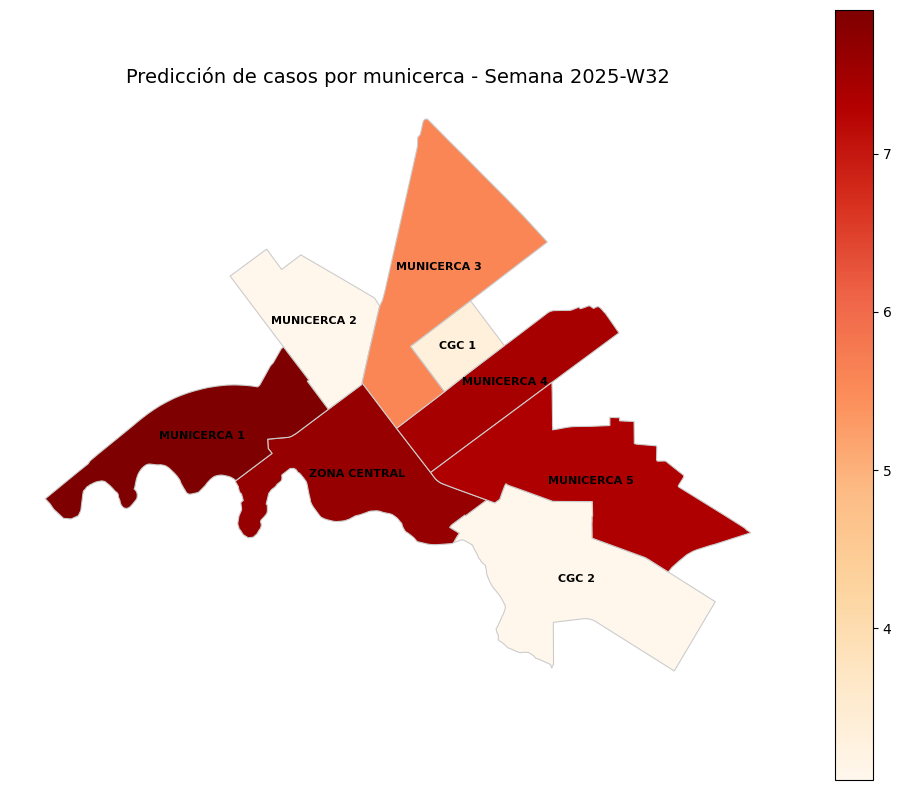

,municerca,year_week,casos_pred
2,MUNICERCA 1,2025-W32,7.91
7,ZONA CENTRAL,2025-W32,7.62
5,MUNICERCA 4,2025-W32,7.45
6,MUNICERCA 5,2025-W32,7.35
4,MUNICERCA 3,2025-W32,5.58
0,CGC 1,2025-W32,3.34
1,CGC 2,2025-W32,3.05
3,MUNICERCA 2,2025-W32,3.04


In [21]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt

# 1. Cargar shapefile
gdf_municerca = gpd.read_file(r"Datos\infra y mov/Capa de Municercas/NuevaDistribucion2024.shp")
gdf_municerca=gdf_municerca.rename(columns={"Nombre":"municerca"})

# 2. Tu DataFrame de predicciones
df_pred = pd.DataFrame({
    "municerca": [
        "CGC 1", "CGC 2", "MUNICERCA 1", "MUNICERCA 2",
        "MUNICERCA 3", "MUNICERCA 4", "MUNICERCA 5", "ZONA CENTRAL"
    ],
    "year_week": ["2025-W32"] * 8,
    "casos_pred": [3.34, 3.05, 7.91, 3.04, 5.58, 7.45, 7.35, 7.62]
})

# 3. Unir shapefile con predicciones
gdf_plot = gdf_municerca.merge(df_pred, on="municerca", how="left")

# 4. Graficar heatmap
fig, ax = plt.subplots(figsize=(10, 8))
gdf_plot.plot(column="casos_pred", cmap="OrRd", linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)

# 5. Agregar nombres centrados
for _, row in gdf_plot.iterrows():
    if row['geometry'].is_empty:
        continue
    centroid = row['geometry'].centroid
    ax.text(centroid.x, centroid.y, row['municerca'], fontsize=8,
            ha='center', va='center', color='black', weight='bold')

# 6. Estética
ax.set_title("Predicción de casos por municerca - Semana 2025-W32", fontsize=14)
ax.axis("off")

plt.tight_layout()
plt.show()
display(df_pred.sort_values('casos_pred',ascending=False))

In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip
import webbrowser
import os

# 1. Cargar shapefile
gdf_municerca = gpd.read_file(r"Datos\infra y mov/Capa de Municercas/NuevaDistribucion2024.shp")
gdf_municerca=gdf_municerca.rename(columns={"Nombre":"municerca"})



# 3. Unir shapefile con predicciones
gdf_plot = gdf_municerca.merge(df_pred, on="municerca", how="left")

# 4. Crear mapa centrado en el centroide general
centro = gdf_plot.geometry.centroid.unary_union.centroid
m = folium.Map(location=[centro.y, centro.x], zoom_start=12)

# 5. Añadir capa con tooltip
folium.GeoJson(
    gdf_plot,
    name="Predicción de casos",
    style_function=lambda feature: {
        'fillColor': '#FF5733',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=["municerca", "casos_pred"],
        aliases=["Zona", "Casos predichos"],
        localize=True
    )
).add_to(m)

# 6. Guardar mapa como HTML
output_file = "outputs\\mapa_predicciones.html"
m.save(output_file)
print(f"✔ Mapa guardado en: {output_file}")

# 7. Abrir en navegador por defecto
webbrowser.open('file://' + os.path.realpath(output_file))


C:\Users\Nainh\AppData\Local\Temp\ipykernel_6676\1802936622.py:18: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  centro = gdf_plot.geometry.centroid.unary_union.centroid


✔ Mapa guardado en: mapa_predicciones.html


True

In [ ]:
import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip
import webbrowser
import os

# 1. Cargar shapefile y reproyectar
gdf_municerca = gpd.read_file(r"Datos\infra y mov/Capa de Municercas/NuevaDistribucion2024.shp")
gdf_municerca=gdf_municerca.rename(columns={"Nombre":"municerca"})
gdf_municerca = gdf_municerca.to_crs(epsg=4326)  # Asegura coordenadas lat/lon

# 2. DataFrame de predicciones
df_pred = pd.DataFrame({
    "municerca": [
        "CGC 1", "CGC 2", "MUNICERCA 1", "MUNICERCA 2",
        "MUNICERCA 3", "MUNICERCA 4", "MUNICERCA 5", "ZONA CENTRAL"
    ],
    "year_week": ["2025-W32"] * 8,
    "casos_pred": [3.34, 3.05, 7.91, 3.04, 5.58, 7.45, 7.35, 7.62]
})

# 3. Merge con geometría
gdf_plot = gdf_municerca.merge(df_pred, on="municerca", how="left")

# 4. Crear mapa (centrado en los bounds del shapefile)
bounds = gdf_plot.total_bounds  # [minx, miny, maxx, maxy]
map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
m = folium.Map(location=map_center, zoom_start=13)

# 5. Añadir capa GeoJson con tooltip
geojson = folium.GeoJson(
    gdf_plot,
    name="Predicción de casos",
    style_function=lambda feature: {
        'fillColor': '#FF5733',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=["municerca", "casos_pred"],
        aliases=["Zona", "Casos predichos"],
        localize=True
    )
)
geojson.add_to(m)

# 6. Ajustar vista al contenido
m.fit_bounds([[bounds[1], bounds[0]], [bounds[3], bounds[2]]])

# 7. Guardar y abrir
output_file = "outputs\\mapa_predicciones.html"
m.save(output_file)
print(f"✔ Mapa guardado en: {output_file}")
webbrowser.open('file://' + os.path.realpath(output_file))


✔ Mapa guardado en: mapa_predicciones.html


True

In [24]:
import geopandas as gpd
import pandas as pd
import folium
from folium.features import GeoJsonTooltip
import webbrowser
import os
import branca.colormap as cm

# 1. Cargar y reproyectar shapefile
gdf_municerca = gpd.read_file(r"Datos\infra y mov/Capa de Municercas/NuevaDistribucion2024.shp")
gdf_municerca=gdf_municerca.rename(columns={"Nombre":"municerca"})
gdf_municerca = gdf_municerca.to_crs(epsg=4326)

# 2. DataFrame de predicciones
df_pred = pd.DataFrame({
    "municerca": [
        "CGC 1", "CGC 2", "MUNICERCA 1", "MUNICERCA 2",
        "MUNICERCA 3", "MUNICERCA 4", "MUNICERCA 5", "ZONA CENTRAL"
    ],
    "year_week": ["2025-W32"] * 8,
    "casos_pred": [3.34, 3.05, 7.91, 3.04, 5.58, 7.45, 7.35, 7.62]
})

# 3. Merge
gdf_plot = gdf_municerca.merge(df_pred, on="municerca", how="left")

# 4. Colormap dinámico según rango de valores
min_val = gdf_plot["casos_pred"].min()
max_val = gdf_plot["casos_pred"].max()
colormap = cm.linear.OrRd_09.scale(min_val, max_val)
colormap.caption = "Casos predichos"

# 5. Crear mapa centrado
bounds = gdf_plot.total_bounds
map_center = [(bounds[1] + bounds[3]) / 2, (bounds[0] + bounds[2]) / 2]
m = folium.Map(location=map_center, zoom_start=13)

# 6. Añadir capa coloreada
folium.GeoJson(
    gdf_plot,
    name="Predicción de casos",
    style_function=lambda feature: {
        'fillColor': colormap(feature['properties']['casos_pred']) if feature['properties']['casos_pred'] is not None else 'transparent',
        'color': 'black',
        'weight': 1,
        'fillOpacity': 0.7,
    },
    tooltip=GeoJsonTooltip(
        fields=["municerca", "casos_pred"],
        aliases=["Zona", "Casos predichos"],
        localize=True
    )
).add_to(m)

# 7. Añadir leyenda
colormap.add_to(m)




from datetime import datetime
from folium import Element

# Obtener fecha de hoy
fecha_hoy = datetime.today().strftime("%Y-%m-%d")

# Obtener semana predicha (usás el mismo valor que en tu df_pred)
semana_predicha = df_pred["year_week"].iloc[0]

hoy = datetime.today()
semana_actual = f"{hoy.isocalendar().year}-W{hoy.isocalendar().week:02d}"

# Crear HTML para mostrar en el mapa
info_html = f"""
<div style="
    position: fixed;
    bottom: 10px;
    left: 10px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid gray;
    border-radius: 5px;
    font-size: 14px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
">
    <b>Fecha de generación:</b> {fecha_hoy}<br>
    <b>Semana actual:</b> {semana_actual}<br>
    <b>Semana predicha:</b> {semana_predicha}
</div>
"""

m.get_root().html.add_child(Element(info_html))

import base64

# Leer la imagen y convertir a base64
with open(r"outputs\importancia_variables.png", "rb") as img_file:
    img_base64 = base64.b64encode(img_file.read()).decode("utf-8")



tabla_html = df_results.to_html(index=False, border=0, justify="center", classes="tabla-resultados")

# Estilo CSS para que la tabla se vea mejor
tabla_contenedor = f"""
<div style="
    position: fixed;
    bottom: 10px;
    right: 10px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid gray;
    border-radius: 5px;
    font-size: 13px;
    max-width: 300px;
    overflow-x: auto;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
">
    <b>Resultados de modelos:</b><br>
    {tabla_html}
</div>
"""

# Agregar al mapa
m.get_root().html.add_child(Element(tabla_contenedor))

# Bloque HTML para imagen
img_html = f"""
<div style="
    position: fixed;
    top: 10px;
    left: 10px;
    z-index: 9999;
    background-color: white;
    padding: 10px;
    border: 2px solid gray;
    border-radius: 5px;
    box-shadow: 2px 2px 5px rgba(0,0,0,0.3);
    max-width: 400px;
">
    <b>Importancia de variables (Top 10)</b><br>
    <img src="data:image/png;base64,{img_base64}" style="width: 100%; height: auto;">
</div>
"""

m.get_root().html.add_child(Element(img_html))

# 8. Guardar y abrir
output_file = "mapa_predicciones.html"
m.save(output_file)
import subprocess

# Ruta al ejecutable de Edge (por defecto en Windows 10/11)
edge_path = r"C:\Program Files (x86)\Microsoft\Edge\Application\msedge.exe"
file_url = 'file://' + os.path.realpath(output_file)

# Ejecutar Edge con el archivo
subprocess.run([edge_path, file_url])


CompletedProcess(args=['C:\\Program Files (x86)\\Microsoft\\Edge\\Application\\msedge.exe', 'file://C:\\Users\\Nainh\\Proton Drive\\nainho1306\\My files\\Licitacion\\Plataforma local\\Modelo\\mapa_predicciones.html'], returncode=0)